# 0. 기본세팅

In [ ]:
# 백테스팅 설치
# !pip install backtesting
# AutoTS 설치
# !pip install autots
# FinanceDataReader 설치
# !pip install -U finance-datareader

In [ ]:
# 데이터 전처리
import pandas as pd
import numpy as np
from datetime import datetime

# 시각화
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
color = sns.color_palette()
sns.set_style('darkgrid')

# Backtesting 
from backtesting import Backtest, Strategy 
from backtesting.lib import crossover
# AutoTS
from autots import AutoTS

# FinanceDataReader 
import FinanceDataReader as fdr

In [ ]:
# 한글 폰트를 사용하기 위한 코드
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
# 경고 무시
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 구글 드라이브에서 파일 불러오기
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# 1. 데이터 확인

In [ ]:
#  kospi 데이터 가져오기
kospi_df = pd.read_csv('/content/gdrive/MyDrive/data/kospi_data.csv')
kospi_df.head()

,Date,Close,Open,High,Low,Volume,Change
0,1981-05-01,123.6,123.6,123.6,123.6,3330000.0,0.0098
1,1981-05-02,123.5,123.5,123.5,123.5,2040000.0,-0.0008
2,1981-05-04,120.6,120.6,120.6,120.6,1930000.0,-0.0235
3,1981-05-06,120.7,120.7,120.7,120.7,1690000.0,0.0008
4,1981-05-07,119.3,119.3,119.3,119.3,1480000.0,-0.0116


In [ ]:
# 기본정보 확인하기
kospi_df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11024 entries, 0 to 11023
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    11024 non-null  object 
 1   Close   11024 non-null  float64
 2   Open    11024 non-null  float64
 3   High    11024 non-null  float64
 4   Low     11024 non-null  float64
 5   Volume  11024 non-null  float64
 6   Change  11024 non-null  float64
dtypes: float64(6), object(1)
memory usage: 603.0+ KB


In [ ]:
# 통계정보 확인하기
round(kospi_df.describe(), 3)

,Close,Open,High,Low,Volume,Change
count,11024.000,11024.000,11024.000,11024.000,1.102400e+04,11024.000
mean,1121.078,1121.552,1127.448,1114.365,2.556932e+08,0.000
std,772.892,773.393,777.129,768.310,2.938432e+08,0.015
min,105.990,105.990,105.990,105.990,1.660000e+05,-0.120
25%,586.562,586.482,589.730,582.838,1.208750e+07,-0.006
50%,878.105,878.015,882.360,873.430,2.264900e+08,0.000
75%,1891.347,1892.090,1902.320,1880.635,4.028000e+08,0.007
max,3305.210,3305.460,3316.080,3295.440,3.460000e+09,0.120


In [ ]:
# 결측치 확인하기
kospi_df.isnull().sum()

Date      0
Close     0
Open      0
High      0
Low       0
Volume    0
Change    0
dtype: int64

# 2. 데이터 전처리

In [ ]:
# "Date"를 날짜형으로 변경하기
kospi_df['Date'] = pd.to_datetime(kospi_df['Date'])
# index를 Date로 변경하기
kospi_df = kospi_df.set_index('Date')
kospi_df.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1981-05-01,123.6,123.6,123.6,123.6,3330000.0,0.0098
1981-05-02,123.5,123.5,123.5,123.5,2040000.0,-0.0008
1981-05-04,120.6,120.6,120.6,120.6,1930000.0,-0.0235
1981-05-06,120.7,120.7,120.7,120.7,1690000.0,0.0008
1981-05-07,119.3,119.3,119.3,119.3,1480000.0,-0.0116


# 3. 시각화

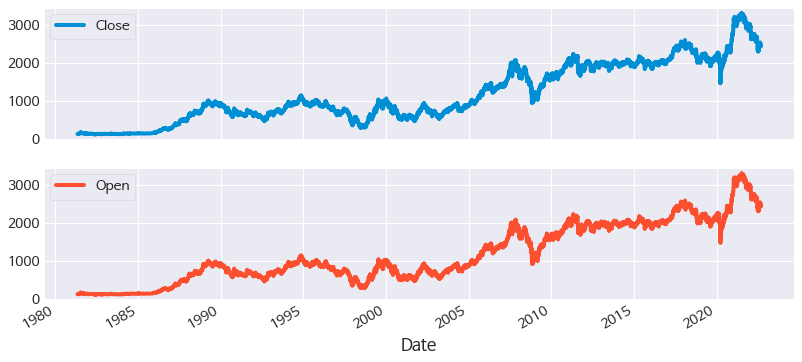

In [ ]:
# 종가, 시가 추세 비교하기
kospi_df[['Close', 'Open']].plot(subplots=True, layout=(2,1), figsize=(12,6))
plt.legend()
plt.show()

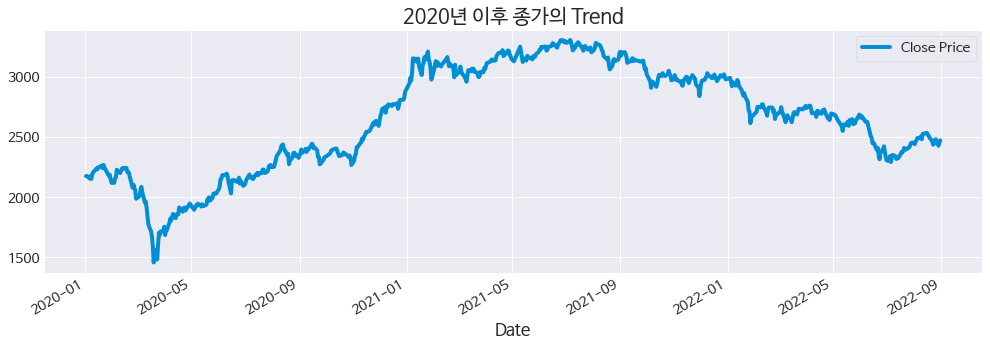

In [ ]:
# 2020년 이후의 종가("Close")만 살펴보기
kospi_after_2020 = kospi_df[kospi_df.index > '2020-01-01']
kospi_after_2020['Close'].plot(figsize=(15,5), title="2020년 이후 종가의 Trend", label="Close Price")
plt.legend()
plt.show()

In [ ]:
# 2020년 이후 코스피가 가장 낮았던 날은 2020-03-19
kospi_after_2020[kospi_after_2020['Close'] == kospi_after_2020['Close'].min()]

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2020-03-19,1457.64,1626.09,1626.09,1439.43,977670000.0,-0.0839


* 전체적으로 봤을 때, 코스피는 상승하는 추세임
* 2020년 3월에 크게 하락한 뒤로 다시 오르다가 2021년 7월쯤부터 하향 추세를 보임

## 3-1. 컬럼별 분포 비교

In [ ]:
# histogram, boxplot, violinplot으로 컬럼들의 분포 비교하는 함수 생성
def three_plots(x, title, c):
    fig, ax = plt.subplots(3, 1, figsize=(15, 7), sharex=True)
    sns.histplot(data=kospi_df, x=x, kde=True, ax=ax[0],color=c).set_title('Histogram')
    sns.boxplot(data=kospi_df, x=x, ax=ax[1], color=c).set_title('Boxplot')
    sns.violinplot(data=kospi_df, x=x, ax=ax[2], color=c).set_title('Violin plot')
    fig.suptitle(title, fontsize=25)  # 메인 타이틀 추가
    plt.tight_layout(pad=3.0)
    
    plt.show()

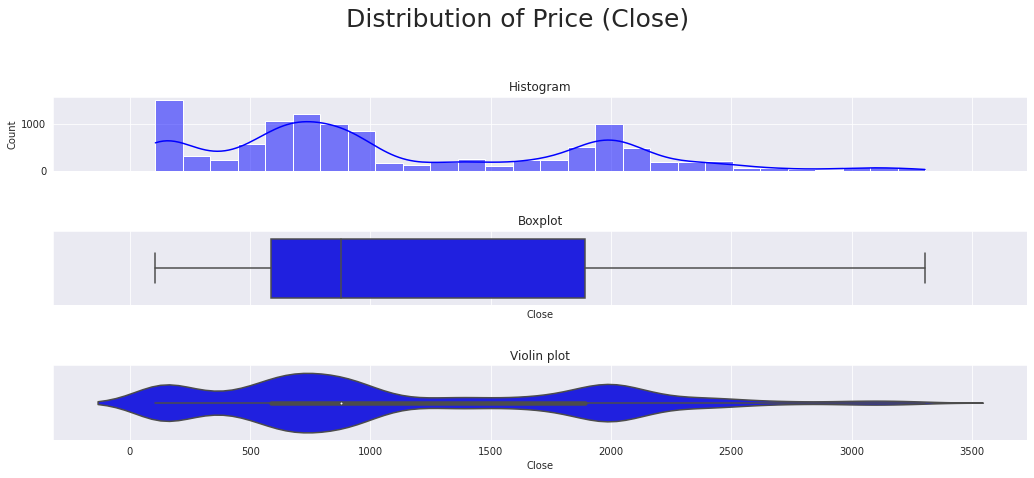

In [ ]:
# 종가("Close") 시각화
three_plots(kospi_df['Close'], 'Distribution of Price (Close)', "blue")

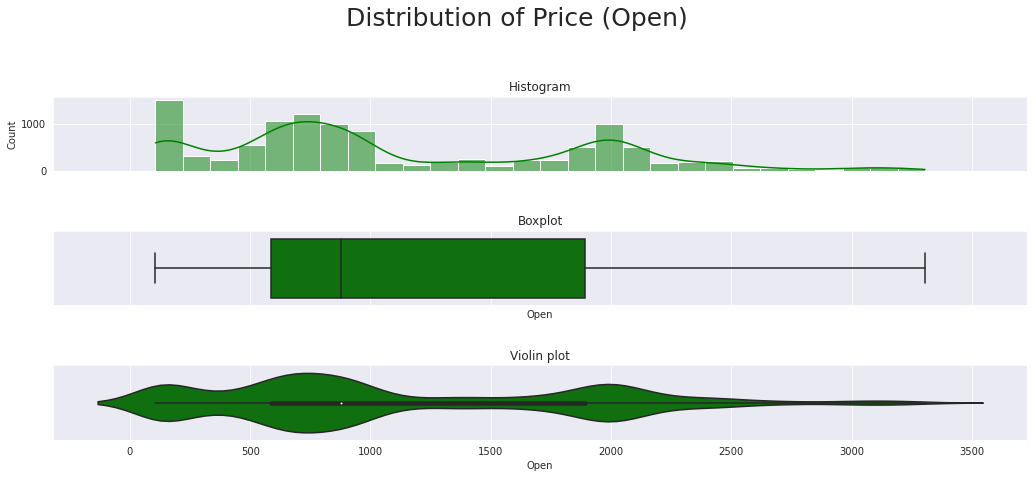

In [ ]:
# 시가("Open") 시각화
three_plots(kospi_df['Open'], 'Distribution of Price (Open)', "green")

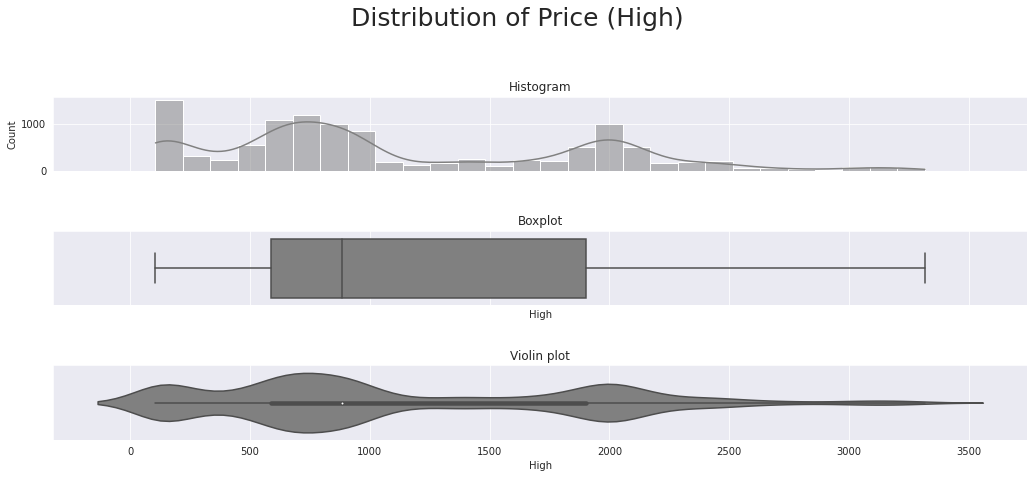

In [ ]:
# 고가("High") 시각화
three_plots(kospi_df['High'], 'Distribution of Price (High)', "gray")

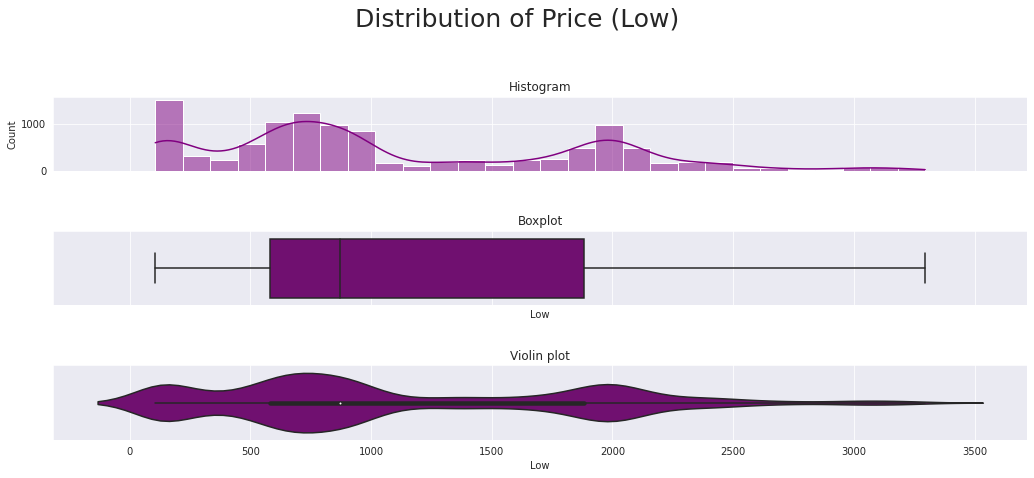

In [ ]:
# 저가("Low") 시각화
three_plots(kospi_df['Low'], 'Distribution of Price (Low)', "purple")

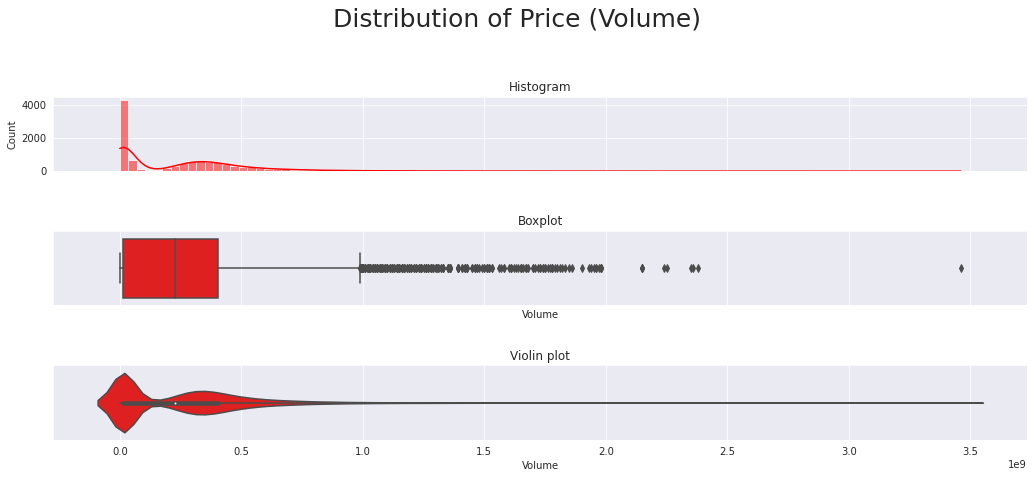

In [ ]:
# 거래량("Volume") 시각화
three_plots(kospi_df['Volume'], 'Distribution of Price (Volume)', "red")

## 3-2. 상관관계

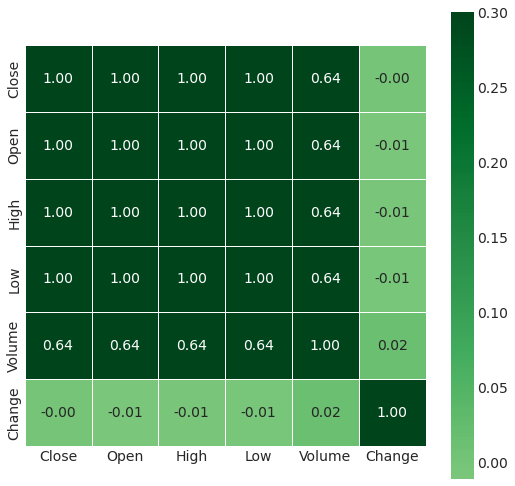

In [ ]:
# 상관관계 시각화
plt.figure(figsize=(8,8))
corr = kospi_df.corr()
sns.heatmap(corr, cmap="Greens", annot=True, linewidths=0.5, vmax=0.3, 
            center=0, square=True, fmt=".2f", cbar=True)
plt.show()

* "Close", "Open", "High", "Low" 컬럼의 값이 비슷함

## 3-3. 인터랙티브 차트

In [ ]:
# 캔들스틱 차트 시각화 (plotly)
fig = go.Figure(data=[go.Candlestick(x=kospi_df.index, 
                                     open=kospi_df['Open'], 
                                     high=kospi_df['High'], 
                                     low=kospi_df['Low'],
                                     close=kospi_df['Close'])])

fig.update_layout(title="<b>KOSPI 주식 트레이딩</b>",
                  yaxis_title="KOSPI STOCK",
                  shapes=[dict(x0='2020-05-30', x1='2020-05-30', y0=0, y1=1, xref='x', yref='paper', line_width=2, type='line')],
                  annotations=[dict(x='2020-05-30', y=0.05, xref='x', yref='paper', showarrow=False, xanchor='left', text='Increase Period Begins')])   # 주석 넣기
fig.show()

## 3-4. Backtesting

* **백테스팅(Backtesting)**: 개발된 알고리즘을 과거 데이터를 사용해 검증해보는 것
    * 과거 데이터를 사용하기 때문에 back, 알고리즘을 테스트하기 때문에 testing이라는 영어 단어가 사용됨
* 나의 전략이 과거에 어떻게 수행되었는지, 성과는 어땠는지 확인하여 좋은 결과가 나올 경우 미래 투자에 적용해 볼 수 있음
* "Final"로 수익률 볼 수 있음

In [ ]:
# Backtesting
from backtesting.test import SMA, GOOG

# Strategy(전략) 설정 클래스 생성
class SmaCross(Strategy):
    # 20일, 60일 이동평균선
    n1 = 20
    n2 = 60

    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, self.n1)
        self.ma2 = self.I(SMA, price, self.n2)
    # 20일 이동평균선과 60일 이동평균선이 cross하면 전량 매수 / 전량 매도
    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.position.close()

# 현금 1억, 커미션 0.015%로 백테스팅 설정
bt = Backtest(kospi_df, SmaCross, commission=0.015, cash=100000000,
              exclusive_orders=True)
# 백테스팅 실행
stats = bt.run()

In [ ]:
# 백테스팅 상세 정보
stats

Start                     1981-05-01 00:00:00
End                       2022-08-31 00:00:00
Duration                  15097 days 00:00:00
Exposure Time [%]                   54.989115
Equity Final [$]             345115326.099852
Equity Peak [$]              601511268.673701
Return [%]                         245.115326
Buy & Hold Return [%]             1900.040453
Return (Ann.) [%]                    2.872061
Volatility (Ann.) [%]               15.770742
Sharpe Ratio                         0.182113
Sortino Ratio                        0.268432
Calmar Ratio                         0.050479
Max. Drawdown [%]                  -56.896352
Avg. Drawdown [%]                     -5.4041
Max. Drawdown Duration     5516 days 00:00:00
Avg. Drawdown Duration      160 days 00:00:00
# Trades                                   99
Win Rate [%]                        32.323232
Best Trade [%]                      87.795315
Worst Trade [%]                     -17.08898
Avg. Trade [%]                    

* Sharpe Ratio, Sortino Ratio: 리스크에 비해 수익이 효율적으로 나오는지 확인
* Calmar Ratio: 평균수익률 대비 최대손실
* 최고 수익률: 602%, 현재 수익률: 345%

In [ ]:
# 그래프
bt.plot()

Row(id='1449', ...)

# 4. AutoTS

In [ ]:
close_df = kospi_df.reset_index()[['Date', 'Close']]

In [ ]:
# AutoTS으로 Kospi 주식 훈련하기 
model = AutoTS(forecast_length = 10, frequency = 'infer', ensemble = 'simple', drop_data_older_than_periods = 200)
model = model.fit(close_df, date_col = "Date", value_col = "Close", id_col = None)

Inferred frequency is: B
Old data dropped by `drop_data_older_than_periods`.
Model Number: 1 with model ARIMA in generation 0 of 10
Model Number: 2 with model AverageValueNaive in generation 0 of 10
Model Number: 3 with model AverageValueNaive in generation 0 of 10
Model Number: 4 with model AverageValueNaive in generation 0 of 10
Model Number: 5 with model DatepartRegression in generation 0 of 10
Model Number: 6 with model DatepartRegression in generation 0 of 10
Model Number: 7 with model DatepartRegression in generation 0 of 10
Model Number: 8 with model DatepartRegression in generation 0 of 10
Epoch 1/50
6/6 [==============================] - 7s 7ms/step - loss: 0.3922
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 0.3879
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 0.3835
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 0.3785
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 0.3744
Epoch 6/50

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/nojm6ixw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/fgd0iqua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67043', 'data', 'file=/tmp/tmpce83mwo7/nojm6ixw.json', 'init=/tmp/tmpce83mwo7/fgd0iqua.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelyuphizvv/prophet_model-20230317130111.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:01:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:01:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 37 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 37: GluonTS
Model Number: 38 with model MultivariateRegression in generation 0 of 10


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n

Model Number: 39 with model MultivariateRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 39: MultivariateRegression
Model Number: 40 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 40: DatepartRegression
Model Number: 41 with model SeasonalNaive in generation 0 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 42 with model DatepartRegression in generation 0 of 10
Model Number: 43 with model UnobservedComponents in generation 0 of 10
Model Number: 44 with model UnobservedComponents in generation 0 of 10
Model Number: 45 with model ETS in generation 0 of 10
Model Number: 46 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 46: VECM
Model Number: 47 with model ARDL in generation 0 of 10
Model Number: 48 with model MultivariateMotif in generation 0 of 10
Model Number: 49 with model MultivariateMotif in generation 0 of 10
Model Number: 50 with model UnivariateMotif in generation 0 of 10
Model Number: 51 with model UnivariateMotif in generation 0 of 10
Model Number: 52 with model SectionalMotif in generation 0 of 10
Model Number: 53 with model SectionalMotif in generation 0 of 10
Model Number: 54 with model MultivariateRegression in generation 0 of 10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/043omed2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/tgvf2e2t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57034', 'data', 'file=/tmp/tmpce83mwo7/043omed2.json', 'init=/tmp/tmpce83mwo7/tgvf2e2t.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modely7_scbpu/prophet_model-20230317130114.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:01:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model Number: 55 with model FBProphet in generation 0 of 10


13:01:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 56 with model SeasonalNaive in generation 0 of 10
Model Number: 57 with model DatepartRegression in generation 0 of 10


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 58 with model NVAR in generation 0 of 10
Model Number: 59 with model Theta in generation 0 of 10
Model Number: 60 with model UnivariateRegression in generation 0 of 10
Template Eval Error: ValueError('Input X contains NaN.\nDecisionTreeRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in model 60: UnivariateRegression
Model Number: 61 with model ARCH in generation 0 of 10
Template Eval Error: ImportError('`arch` package 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/o7c5jbxk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/89bin7wf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98968', 'data', 'file=/tmp/tmpce83mwo7/o7c5jbxk.json', 'init=/tmp/tmpce83mwo7/89bin7wf.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelnuyrx5os/prophet_model-20230317130116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:01:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:01:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 70 with model GluonTS in generation 0 of 10
Template Eval Error: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.') in model 70: GluonTS
Model Number: 71 with model UnobservedComponents in generation 0 of 10
Model Number: 72 with model VAR in generation 0 of 10
HolidayTransformer: no anomalies detected.
Template Eval Error: ValueError('Only gave one variable to VAR') in model 72: VAR
Model Number: 73 with model VECM in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VECM') in model 73: VECM
Model Number: 74 with model ARIMA in generation 0 of 10
Model Number: 75 with model WindowRegression in generation 0 of 10
Template Eval Error: KeyError('model') in model 75: WindowRegression
Model Number: 76 with model DatepartRegression in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 76: DatepartRegression
Model Number: 77 with model Univa

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 112 with model MetricMotif in generation 0 of 10
Model Number: 113 with model AverageValueNaive in generation 0 of 10
Model Number: 114 with model ARDL in generation 0 of 10
Model Number: 115 with model ARDL in generation 0 of 10
Model Number: 116 with model SeasonalNaive in generation 0 of 10
Model Number: 117 with model SeasonalNaive in generation 0 of 10
Model Number: 118 with model ARDL in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 118: ARDL
Model Number: 119 with model ConstantNaive in generation 0 of 10
Model Number: 120 with model ARIMA in generation 0 of 10
Model Number: 121 with model ARCH in generation 0 of 10
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 121: ARCH
Model Number: 122 with model Theta in generation 0 of 10
Model Number: 123 with model UnivariateMotif in generation 0 of 10
Model Number: 124 with model UnivariateMotif in generation 0

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 126 with model GLM in generation 0 of 10
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 126: GLM
Model Number: 127 with model LastValueNaive in generation 0 of 10
Model Number: 128 with model SectionalMotif in generation 0 of 10
Model Number: 129 with model ConstantNaive in generation 0 of 10
Model Number: 130 with model UnivariateMotif in generation 0 of 10
Model Number: 131 with model SeasonalNaive in generation 0 of 10
Model Number: 132 with model VAR in generation 0 of 10
Template Eval Error: ValueError('Only gave one variable to VAR') in model 132: VAR
Model Number: 133 with model UnivariateMotif in generation 0 of 10
Model Number: 134 with model SeasonalNaive in generation 0 of 10
Model Number: 135 with model ARCH in generation 0 of 10
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 135: ARCH
Model Number: 136 with model LastValueNaive in generation 0 of 10
Model Number: 137 with

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/n92d9be0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/pz7ub5lt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85032', 'data', 'file=/tmp/tmpce83mwo7/n92d9be0.json', 'init=/tmp/tmpce83mwo7/pz7ub5lt.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelquc200au/prophet_model-20230317130128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:01:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Template Eval Error: ImportError('`arch` package must be installed from pip') in model 170: ARCH
Model Number: 171 with model FBProphet in generation 0 of 10


13:01:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 172 with model AverageValueNaive in generation 0 of 10
Model Number: 173 with model MultivariateMotif in generation 0 of 10
Model Number: 174 with model Theta in generation 0 of 10
Model Number: 175 with model GLM in generation 0 of 10
Model Number: 176 with model UnivariateMotif in generation 0 of 10
Model Number: 177 with model ARDL in generation 0 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 177: ARDL
Model Number: 178 with model MultivariateMotif in generation 0 of 10
Model Number: 179 with model NVAR in generation 0 of 10
Model Number: 180 with model UnivariateMotif in generation 0 of 10
Model Number: 181 with model Theta in generation 0 of 10
Model Number: 182 with model SectionalMotif in generation 0 of 10
Model Number: 183 with model ARIMA in generation 0 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 183: ARIMA
Model Number: 184 with model VECM in generation 0 of 10


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n

Model Number: 250 with model AverageValueNaive in generation 1 of 10
Model Number: 251 with model MetricMotif in generation 1 of 10
Model Number: 252 with model NVAR in generation 1 of 10
Model Number: 253 with model ETS in generation 1 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 253: ETS
Model Number: 254 with model UnobservedComponents in generation 1 of 10
Model Number: 255 with model FBProphet in generation 1 of 10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/s02vm60e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/phtqxppf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74376', 'data', 'file=/tmp/tmpce83mwo7/s02vm60e.json', 'init=/tmp/tmpce83mwo7/phtqxppf.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelwk4rvwni/prophet_model-20230317130216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:02:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:02:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 256 with model UnivariateMotif in generation 1 of 10
Model Number: 257 with model Theta in generation 1 of 10
Model Number: 258 with model UnobservedComponents in generation 1 of 10
Model Number: 259 with model ARDL in generation 1 of 10
Model Number: 260 with model AverageValueNaive in generation 1 of 10
Model Number: 261 with model SectionalMotif in generation 1 of 10
Model Number: 262 with model SeasonalNaive in generation 1 of 10
Model Number: 263 with model SeasonalNaive in generation 1 of 10
Model Number: 264 with model Theta in generation 1 of 10
Model Number: 265 with model ETS in generation 1 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on Close with ValueError('Can only dampen the trend component')
Model Number: 266 with model DatepartRegression in generation 1 of 10
Model Number: 267 with model DatepartRegression in generation 1 of 10


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 268 with model UnobservedComponents in generation 1 of 10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/50c0fulp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/zp4b5xx1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48288', 'data', 'file=/tmp/tmpce83mwo7/50c0fulp.json', 'init=/tmp/tmpce83mwo7/zp4b5xx1.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model7zz98l_e/prophet_model-20230317130219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:02:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model Number: 269 with model FBProphet in generation 1 of 10


13:02:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 270 with model UnivariateMotif in generation 1 of 10
Model Number: 271 with model ConstantNaive in generation 1 of 10
Model Number: 272 with model LastValueNaive in generation 1 of 10
Model Number: 273 with model ARIMA in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 273: ARIMA
Model Number: 274 with model NVAR in generation 1 of 10
Model Number: 275 with model GLM in generation 1 of 10
Model Number: 276 with model MultivariateMotif in generation 1 of 10
Model Number: 277 with model MultivariateMotif in generation 1 of 10
Model Number: 278 with model LastValueNaive in generation 1 of 10
Model Number: 279 with model ETS in generation 1 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on Close with ValueError('Can only dampen the trend component')
Model Number: 280 with model ARIMA in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but future_regr

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 297 with model SectionalMotif in generation 1 of 10
Model Number: 298 with model UnivariateMotif in generation 1 of 10
Model Number: 299 with model LastValueNaive in generation 1 of 10
Model Number: 300 with model ETS in generation 1 of 10
Model Number: 301 with model UnobservedComponents in generation 1 of 10
Model Number: 302 with model SeasonalNaive in generation 1 of 10
Model Number: 303 with model MetricMotif in generation 1 of 10
Model Number: 304 with model AverageValueNaive in generation 1 of 10
Model Number: 305 with model ARDL in generation 1 of 10
Model Number: 306 with model NVAR in generation 1 of 10
Model Number: 307 with model DatepartRegression in generation 1 of 10


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 308 with model ARDL in generation 1 of 10
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 308: ARDL
Model Number: 309 with model DatepartRegression in generation 1 of 10
Model Number: 310 with model ConstantNaive in generation 1 of 10
Model Number: 311 with model UnobservedComponents in generation 1 of 10
New Generation: 2 of 10
Model Number: 312 with model MetricMotif in generation 2 of 10
Model Number: 313 with model MetricMotif in generation 2 of 10
Model Number: 314 with model UnivariateMotif in generation 2 of 10
Model Number: 315 with model MetricMotif in generation 2 of 10
Model Number: 316 with model ETS in generation 2 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on Close with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 317 with model ARIMA in generation 2 of 

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n

Model Number: 331 with model MultivariateRegression in generation 2 of 10


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n

Model Number: 332 with model MultivariateMotif in generation 2 of 10
Model Number: 333 with model WindowRegression in generation 2 of 10
Model Number: 334 with model UnivariateMotif in generation 2 of 10
Model Number: 335 with model UnivariateMotif in generation 2 of 10
Model Number: 336 with model ARIMA in generation 2 of 10
Model Number: 337 with model MetricMotif in generation 2 of 10
Model Number: 338 with model MultivariateMotif in generation 2 of 10
Model Number: 339 with model ConstantNaive in generation 2 of 10
Model Number: 340 with model NVAR in generation 2 of 10
Model Number: 341 with model SectionalMotif in generation 2 of 10
Model Number: 342 with model UnivariateMotif in generation 2 of 10
Model Number: 343 with model DatepartRegression in generation 2 of 10


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 344 with model MetricMotif in generation 2 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 344: MetricMotif
Model Number: 345 with model UnivariateMotif in generation 2 of 10
Model Number: 346 with model MultivariateRegression in generation 2 of 10


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n

Model Number: 347 with model AverageValueNaive in generation 2 of 10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 348 with model FBProphet in generation 2 of 10


DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/zh51eyux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/7um9grto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81785', 'data', 'file=/tmp/tmpce83mwo7/zh51eyux.json', 'init=/tmp/tmpce83mwo7/7um9grto.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model6qippq2n/prophet_model-20230317130237.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:02:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:02:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 349 with model GLM in generation 2 of 10
Model Number: 350 with model AverageValueNaive in generation 2 of 10
Model Number: 351 with model ETS in generation 2 of 10
Model Number: 352 with model LastValueNaive in generation 2 of 10
Model Number: 353 with model DatepartRegression in generation 2 of 10


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 354 with model SeasonalNaive in generation 2 of 10
Model Number: 355 with model LastValueNaive in generation 2 of 10
Model Number: 356 with model NVAR in generation 2 of 10
Model Number: 357 with model ARDL in generation 2 of 10
Model Number: 358 with model LastValueNaive in generation 2 of 10
Model Number: 359 with model GLS in generation 2 of 10
Model Number: 360 with model Theta in generation 2 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 360: Theta
Model Number: 361 with model FBProphet in generation 2 of 10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/sg7eibla.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/eed7vpij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15812', 'data', 'file=/tmp/tmpce83mwo7/sg7eibla.json', 'init=/tmp/tmpce83mwo7/eed7vpij.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelpd6hiqcg/prophet_model-20230317130238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:02:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:02:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 362 with model SeasonalNaive in generation 2 of 10
Model Number: 363 with model AverageValueNaive in generation 2 of 10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/hv6_91su.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/0nd3dg8j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69988', 'data', 'file=/tmp/tmpce83mwo7/hv6_91su.json', 'init=/tmp/tmpce83mwo7/0nd3dg8j.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model9wdnfkcp/prophet_model-20230317130239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:02:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model Number: 364 with model FBProphet in generation 2 of 10


13:02:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 365 with model ETS in generation 2 of 10
Model Number: 366 with model AverageValueNaive in generation 2 of 10
Model Number: 367 with model SectionalMotif in generation 2 of 10
Model Number: 368 with model ConstantNaive in generation 2 of 10
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'ffill_mean_biased', 'transformations': {'0': 'AlignLastValue'}, 'transformation_params': {'0': {'rows': 1, 'lag': 7, 'method': 'multiplicative', 'strength': 1.0, 'first_value_only': False}}}. fail_on_forecast_nan=True") in model 368: ConstantNaive
Model Number: 369 with model MetricMotif in generation 2 of 10
Model Number: 370 with model SeasonalNaive in generation 2 of 10
Model Number: 371 with model MultivariateMotif in generation 2 of 10
Model Number: 372 with model DatepartRegression in generation 2 of 10
Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 406 with model ARDL in generation 2 of 10
Model Number: 407 with model ConstantNaive in generation 2 of 10
Model Number: 408 with model MetricMotif in generation 2 of 10
Model Number: 409 with model DatepartRegression in generation 2 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 409: DatepartRegression
Model Number: 410 with model MultivariateRegression in generation 2 of 10
Model Number: 411 with model SectionalMotif in generation 2 of 10
Model Number: 412 with model LastValueNaive in generation 2 of 10
Model Number: 413 with model NVAR in generation 2 of 10
Model Number: 414 with model ETS in generation 2 of 10
Model Number: 415 with model NVAR in generation 2 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 415: NVAR
Model Number: 416 with model GLS in generation 2 of 10
Model Number: 417 with model MetricMotif in generation 2 of 10
Model Number: 418 with model UnobservedC

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n

Model Number: 469 with model NVAR in generation 3 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


Model Number: 470 with model LastValueNaive in generation 3 of 10
Model Number: 471 with model MultivariateRegression in generation 3 of 10
Model Number: 472 with model NVAR in generation 3 of 10
Model Number: 473 with model UnivariateMotif in generation 3 of 10
Model Number: 474 with model DatepartRegression in generation 3 of 10
Model Number: 475 with model AverageValueNaive in generation 3 of 10
Model Number: 476 with model SeasonalNaive in generation 3 of 10
Model Number: 477 with model UnivariateMotif in generation 3 of 10
Model Number: 478 with model UnivariateMotif in generation 3 of 10
Model Number: 479 with model LastValueNaive in generation 3 of 10
Model Number: 480 with model AverageValueNaive in generation 3 of 10
Model Number: 481 with model MetricMotif in generation 3 of 10
Model Number: 482 with model MultivariateRegression in generation 3 of 10
Model Number: 483 with model SeasonalNaive in generation 3 of 10
Model Number: 484 with model ETS in generation 3 of 10
Model N

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n

Model Number: 496 with model Theta in generation 3 of 10
Model Number: 497 with model SectionalMotif in generation 3 of 10
Model Number: 498 with model MetricMotif in generation 3 of 10
Model Number: 499 with model Theta in generation 3 of 10
Model Number: 500 with model MultivariateMotif in generation 3 of 10
Model Number: 501 with model GLM in generation 3 of 10
Model Number: 502 with model NVAR in generation 3 of 10
Model Number: 503 with model AverageValueNaive in generation 3 of 10
Model Number: 504 with model AverageValueNaive in generation 3 of 10
Model Number: 505 with model MetricMotif in generation 3 of 10
Model Number: 506 with model WindowRegression in generation 3 of 10
Model Number: 507 with model SeasonalNaive in generation 3 of 10
Model Number: 508 with model ARDL in generation 3 of 10
Model Number: 509 with model ETS in generation 3 of 10
ETS error ValueError('Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.')

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 555 with model Theta in generation 3 of 10
Model Number: 556 with model DatepartRegression in generation 3 of 10
Epoch 1/50
5/5 [==============================] - 12s 393ms/step - loss: 263336.7812 - val_loss: 162426.9688
Epoch 2/50
5/5 [==============================] - 0s 37ms/step - loss: 164448.3281 - val_loss: 118984.8438
Epoch 3/50
5/5 [==============================] - 0s 38ms/step - loss: 131228.9531 - val_loss: 86307.0625
Epoch 4/50
5/5 [==============================] - 0s 39ms/step - loss: 108804.2891 - val_loss: 62162.6445
Epoch 5/50
5/5 [==============================] - 0s 37ms/step - loss: 92483.7109 - val_loss: 42696.3359
Epoch 6/50
5/5 [==============================] - 0s 36ms/step - loss: 45727.5273 - val_loss: 30771.5527
Epoch 7/50
5/5 [==============================] - 0s 37ms/step - loss: 49518.7500 - val_loss: 18281.7891
Epoch 8/50
5/5 [==============================] - 0s 34ms/step - loss: 40768.1641 - val_loss: 10771.2617
Epoch 9/50
5/5 [=========

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/g_unedd2.json


Model Number: 558 with model FBProphet in generation 3 of 10


DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/_oi0i4t3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77568', 'data', 'file=/tmp/tmpce83mwo7/g_unedd2.json', 'init=/tmp/tmpce83mwo7/_oi0i4t3.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelgiteia79/prophet_model-20230317130346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 559 with model MetricMotif in generation 3 of 10
Model Number: 560 with model SeasonalNaive in generation 3 of 10
Model Number: 561 with model UnivariateMotif in generation 3 of 10
New Generation: 4 of 10
Model Number: 562 with model NVAR in generation 4 of 10
Model Number: 563 with model ETS in generation 4 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on Close with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 564 with model ARDL in generation 4 of 10
Model Number: 565 with model MetricMotif in generation 4 of 10
Model Number: 566 with model SectionalMotif in generation 4 of 10
Model Number: 567 with model UnivariateMotif in generation 4 of 10
Model Number: 568 with model AverageValueNaive in generation 4 of 10
Model Number: 569 with model WindowRegression in generation 4 of 10
Model Number: 570 with model AverageValueNai

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/mgbnghr2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/mnr3btwe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38110', 'data', 'file=/tmp/tmpce83mwo7/mgbnghr2.json', 'init=/tmp/tmpce83mwo7/mnr3btwe.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model5guns861/prophet_model-20230317130348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:03:49 - cmdstanpy - ERROR - Chain [1] 

Model Number: 572 with model SeasonalNaive in generation 4 of 10
Model Number: 573 with model WindowRegression in generation 4 of 10
Model Number: 574 with model DatepartRegression in generation 4 of 10


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 575 with model ConstantNaive in generation 4 of 10
Model Number: 576 with model NVAR in generation 4 of 10
Model Number: 577 with model MultivariateMotif in generation 4 of 10
Model Number: 578 with model UnivariateMotif in generation 4 of 10
Model Number: 579 with model SectionalMotif in generation 4 of 10
Model Number: 580 with model AverageValueNaive in generation 4 of 10
Model Number: 581 with model SeasonalNaive in generation 4 of 10
Model Number: 582 with model ARDL in generation 4 of 10
Model Number: 583 with model MetricMotif in generation 4 of 10
Model Number: 584 with model NVAR in generation 4 of 10
Model Number: 585 with model LastValueNaive in generation 4 of 10
Model Number: 586 with model SectionalMotif in generation 4 of 10
Model Number: 587 with model UnobservedComponents in generation 4 of 10
Model Number: 588 with model UnivariateMotif in generation 4 of 10
Model Number: 589 with model GLM in generation 4 of 10
Model Number: 590 with model SeasonalNaive

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 606 with model FBProphet in generation 4 of 10
Model Number: 607 with model MetricMotif in generation 4 of 10
Model Number: 608 with model SeasonalNaive in generation 4 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 608: SeasonalNaive
Model Number: 609 with model UnivariateMotif in generation 4 of 10
Model Number: 610 with model ARDL in generation 4 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 610: ARDL
Model Number: 611 with model MetricMotif in generation 4 of 10
Model Number: 612 with model NVAR in generation 4 of 10
Model Number: 613 with model MultivariateRegression in generation 4 of 10
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 613: MultivariateRegression
Model Number: 614 with model NVAR in generation 4 of 10
Model Number: 615 with model GLM in generation 4 of 10
Model Number: 616 with model AverageValueNaive in generation 4 of

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.

Model Number: 630 with model UnivariateMotif in generation 4 of 10


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


Model Number: 631 with model MultivariateRegression in generation 4 of 10
Model Number: 632 with model MultivariateMotif in generation 4 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 632: MultivariateMotif
Model Number: 633 with model Theta in generation 4 of 10
Model Number: 634 with model MultivariateMotif in generation 4 of 10
Model Number: 635 with model NVAR in generation 4 of 10
Model Number: 636 with model ARDL in generation 4 of 10
Model Number: 637 with model SeasonalNaive in generation 4 of 10
Model Number: 638 with model SeasonalNaive in generation 4 of 10
Model Number: 639 with model LastValueNaive in generation 4 of 10
Model Number: 640 with model ARIMA in generation 4 of 10
Model Number: 641 with model ETS in generation 4 of 10
Model Number: 642 with model UnobservedComponents in generation 4 of 10
Model Number: 643 with model UnivariateMotif in generation 4 of 10
Model Number: 644 with model UnobservedComponents in generation 4 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Model Number: 655 with model FBProphet in generation 4 of 10


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/mq8txljt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/xus6hrm8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73988', 'data', 'file=/tmp/tmpce83mwo7/mq8txljt.json', 'init=/tmp/tmpce83mwo7/xus6hrm8.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model6puaneli/prophet_model-20230317130410.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 656 with model MultivariateMotif in generation 4 of 10
Model Number: 657 with model UnobservedComponents in generation 4 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 657: UnobservedComponents
Model Number: 658 with model DatepartRegression in generation 4 of 10
Model Number: 659 with model ETS in generation 4 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on Close with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 660 with model ARDL in generation 4 of 10
Model Number: 661 with model GLS in generation 4 of 10
Model Number: 662 with model WindowRegression in generation 4 of 10
Model Number: 663 with model Theta in generation 4 of 10
Model Number: 664 with model ARDL in generation 4 of 10
Model Number: 665 with model AverageValueNaive in generation 4 of 10
Model Number: 666 with model MetricM

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model Number: 677 with model ConstantNaive in generation 4 of 10
Model Number: 678 with model LastValueNaive in generation 4 of 10


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 679 with model Theta in generation 4 of 10
Model Number: 680 with model MultivariateRegression in generation 4 of 10
Model Number: 681 with model NVAR in generation 4 of 10
Model Number: 682 with model UnivariateMotif in generation 4 of 10
Model Number: 683 with model ARDL in generation 4 of 10
Model Number: 684 with model ETS in generation 4 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on Close with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 685 with model GLS in generation 4 of 10
Model Number: 686 with model UnobservedComponents in generation 4 of 10
New Generation: 5 of 10
Model Number: 687 with model WindowRegression in generation 5 of 10
Template Eval Error: KeyError('model') in model 687: WindowRegression
Model Number: 688 with model MultivariateRegression in generation 5 of 10
Epoch 1/50
24/24 [=================

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 690 with model MetricMotif in generation 5 of 10
Model Number: 691 with model UnivariateMotif in generation 5 of 10
Model Number: 692 with model MetricMotif in generation 5 of 10
Model Number: 693 with model LastValueNaive in generation 5 of 10
Model Number: 694 with model Theta in generation 5 of 10
Model Number: 695 with model SectionalMotif in generation 5 of 10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/poub2796.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/8o67weu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


Model Number: 696 with model FBProphet in generation 5 of 10


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20077', 'data', 'file=/tmp/tmpce83mwo7/poub2796.json', 'init=/tmp/tmpce83mwo7/8o67weu6.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelsd9n_mku/prophet_model-20230317130452.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 697 with model MetricMotif in generation 5 of 10
Model Number: 698 with model WindowRegression in generation 5 of 10
Model Number: 699 with model LastValueNaive in generation 5 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 699: LastValueNaive
Model Number: 700 with model SeasonalNaive in generation 5 of 10
Model Number: 701 with model DatepartRegression in generation 5 of 10
Model Number: 702 with model SectionalMotif in generation 5 of 10
Model Number: 703 with model ETS in generation 5 of 10
Model Number: 704 with model MultivariateMotif in generation 5 of 10
Model Number: 705 with model WindowRegression in generation 5 of 10
Model Number: 706 with model ARDL in generation 5 of 10
Model Number: 707 with model Theta in generation 5 of 10
Model Number: 708 with model ETS in generation 5 of 10
Model Number: 709 with model MultivariateMotif in generation 5 of 10
Model Number: 710 with model MultivariateMotif in generation 5 of 10
Model Numb

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 785 with model AverageValueNaive in generation 5 of 10
Model Number: 786 with model GLM in generation 5 of 10
New Generation: 6 of 10
Model Number: 787 with model SeasonalNaive in generation 6 of 10
HolidayTransformer: no anomalies detected.
Model Number: 788 with model UnivariateMotif in generation 6 of 10
Model Number: 789 with model UnobservedComponents in generation 6 of 10
Model Number: 790 with model SectionalMotif in generation 6 of 10
HolidayTransformer: no anomalies detected.
Model Number: 791 with model FBProphet in generation 6 of 10

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/7wt014ti.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/ubv45qv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73891', 'data', 'file=/tmp/tmpce83mwo7/7wt014ti.json', 'init=/tmp/tmpce83mwo7/ubv45qv_.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelbhu8ropc/prophet_model-20230317130601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:06:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


13:06:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 792 with model NVAR in generation 6 of 10
Model Number: 793 with model UnivariateMotif in generation 6 of 10
Model Number: 794 with model AverageValueNaive in generation 6 of 10
Model Number: 795 with model GLS in generation 6 of 10
Model Number: 796 with model MultivariateMotif in generation 6 of 10
Model Number: 797 with model UnivariateMotif in generation 6 of 10
Model Number: 798 with model SeasonalNaive in generation 6 of 10
Model Number: 799 with model UnivariateMotif in generation 6 of 10
Model Number: 800 with model LastValueNaive in generation 6 of 10
Model Number: 801 with model UnivariateMotif in generation 6 of 10
Model Number: 802 with model DatepartRegression in generation 6 of 10


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 803 with model MetricMotif in generation 6 of 10
Model Number: 804 with model UnivariateMotif in generation 6 of 10
Model Number: 805 with model DatepartRegression in generation 6 of 10
Model Number: 806 with model LastValueNaive in generation 6 of 10
Model Number: 807 with model ARDL in generation 6 of 10
Model Number: 808 with model ETS in generation 6 of 10
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on Close with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 809 with model ARDL in generation 6 of 10
Model Number: 810 with model ARDL in generation 6 of 10
Model Number: 811 with model Theta in generation 6 of 10
Model Number: 812 with model GLM in generation 6 of 10
Model Number: 813 with model MetricMotif in generation 6 of 10
Model Number: 814 with model MultivariateRegression in generation 6 of 10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/tkdx4p9b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/2mbbbng1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32301', 'data', 'file=/tmp/tmpce83mwo7/tkdx4p9b.json', 'init=/tmp/tmpce83mwo7/2mbbbng1.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelads5sxhv/prophet_model-20230317130605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:06:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:06:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 815 with model FBProphet in generation 6 of 10
Model Number: 816 with model NVAR in generation 6 of 10
Model Number: 817 with model Theta in generation 6 of 10
Model Number: 818 with model MultivariateMotif in generation 6 of 10
Model Number: 819 with model Theta in generation 6 of 10
Model Number: 820 with model ETS in generation 6 of 10
Model Number: 821 with model WindowRegression in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 821: WindowRegression
Model Number: 822 with model AverageValueNaive in generation 6 of 10
Model Number: 823 with model UnivariateMotif in generation 6 of 10
Model Number: 824 with model Theta in generation 6 of 10
Model Number: 825 with model ARDL in generation 6 of 10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/zt_g49ru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/mcszl2qm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97579', 'data', 'file=/tmp/tmpce83mwo7/zt_g49ru.json', 'init=/tmp/tmpce83mwo7/mcszl2qm.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelw6t_gzz3/prophet_model-20230317130606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:06:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model Number: 826 with model FBProphet in generation 6 of 10


13:06:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 827 with model MetricMotif in generation 6 of 10
Template Eval Error: TypeError("'NoneType' object is not subscriptable") in model 827: MetricMotif
Model Number: 828 with model MetricMotif in generation 6 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 828: MetricMotif
Model Number: 829 with model NVAR in generation 6 of 10
Model Number: 830 with model SeasonalNaive in generation 6 of 10
Model Number: 831 with model ETS in generation 6 of 10
Model Number: 832 with model GLM in generation 6 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 832: GLM
Model Number: 833 with model LastValueNaive in generation 6 of 10
Model Number: 834 with model MultivariateRegression in generation 6 of 10
Model Number: 835 with model UnivariateMotif in generation 6 of 10
Model Number: 836 with model DatepartRegression in generation 6 of 10


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


Model Number: 837 with model GLS in generation 6 of 10


[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 838 with model Theta in generation 6 of 10
Model Number: 839 with model ARIMA in generation 6 of 10
Model Number: 840 with model MultivariateMotif in generation 6 of 10
Model Number: 841 with model Theta in generation 6 of 10
Model Number: 842 with model ETS in generation 6 of 10
Model Number: 843 with model ARDL in generation 6 of 10
Template Eval Error: ValueError("ARDL series Close failed with error ValueError('integer orders must be at least 1 when causal is True.') exog train             month  day  weekday  weekend       epoch\nDate                                                \n2021-11-25     11   25        3        0  16377984.0\n2021-11-26     11   26        4        0  16378848.0\n2021-11-29     11   29        0        0  16381440.0\n2021-11-30     11   30        1        0  16382304.0\n2021-12-01     12    1        2        0  16383168.0\n...           ...  ...      ...      ...         ...\n2022-08-11      8   11        3        0  16601760.0\n2022-08-12    

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/3zaz7owy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/v6hz1zo0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52288', 'data', 'file=/tmp/tmpce83mwo7/3zaz7owy.json', 'init=/tmp/tmpce83mwo7/v6hz1zo0.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelejnvzwon/prophet_model-20230317130616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:06:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:06:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 879 with model FBProphet in generation 6 of 10
Model Number: 880 with model Theta in generation 6 of 10
Model Number: 881 with model WindowRegression in generation 6 of 10
Model Number: 882 with model UnobservedComponents in generation 6 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 882: UnobservedComponents
Model Number: 883 with model SeasonalNaive in generation 6 of 10
Model Number: 884 with model LastValueNaive in generation 6 of 10
Template Eval Error: Exception('Transformer BTCD failed on fit') in model 884: LastValueNaive
Model Number: 885 with model GLM in generation 6 of 10
Model Number: 886 with model UnivariateMotif in generation 6 of 10
New Generation: 7 of 10
Model Number: 887 with model SeasonalNaive in generation 7 of 10
Model Number: 888 with model NVAR in generation 7 of 10
Model Number: 889 with model UnivariateMotif in generation 7 of 10
Model Number: 890 with model LastValueNaive in generation

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/t3q_vtho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/ncrz17wn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76995', 'data', 'file=/tmp/tmpce83mwo7/t3q_vtho.json', 'init=/tmp/tmpce83mwo7/ncrz17wn.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model9a_29v7c/prophet_model-20230317130618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:06:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:06:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 897 with model AverageValueNaive in generation 7 of 10
Model Number: 898 with model UnobservedComponents in generation 7 of 10
Model Number: 899 with model MetricMotif in generation 7 of 10
Model Number: 900 with model AverageValueNaive in generation 7 of 10
Model Number: 901 with model SectionalMotif in generation 7 of 10
Model Number: 902 with model MultivariateMotif in generation 7 of 10
Model Number: 903 with model GLS in generation 7 of 10
Model Number: 904 with model NVAR in generation 7 of 10
Model Number: 905 with model LastValueNaive in generation 7 of 10
Model Number: 906 with model AverageValueNaive in generation 7 of 10
Model Number: 907 with model UnobservedComponents in generation 7 of 10
Model Number: 908 with model WindowRegression in generation 7 of 10
Model Number: 909 with model AverageValueNaive in generation 7 of 10
Model Number: 910 with model MetricMotif in generation 7 of 10
Model Number: 911 with model MultivariateRegression in generation 7 of 10


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


Model Number: 980 with model MetricMotif in generation 7 of 10


[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 981 with model ARDL in generation 7 of 10
Model Number: 982 with model GLM in generation 7 of 10
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 982: GLM
Model Number: 983 with model SectionalMotif in generation 7 of 10
Model Number: 984 with model DatepartRegression in generation 7 of 10
Model Number: 985 with model UnobservedComponents in generation 7 of 10
Model Number: 986 with model LastValueNaive in generation 7 of 10
New Generation: 8 of 10
Model Number: 987 with model Theta in generation 8 of 10
Model Number: 988 with model Theta in generation 8 of 10
Model Number: 989 with model MetricMotif in generation 8 of 10
Model Number: 990 with model ETS in generation 8 of 10
ETS error ValueError('Can only dampen the trend component')
ETS failed on Close with ValueError('Can only dampen the trend component')
Model Number: 991 with model ARDL in generation 8 of 10
Model Number: 992 with model ETS in generatio

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/p_4xtyw8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/ax_ppcoe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81501', 'data', 'file=/tmp/tmpce83mwo7/p_4xtyw8.json', 'init=/tmp/tmpce83mwo7/ax_ppcoe.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelvfjmn1s4/prophet_model-20230317130641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:06:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Model Number: 1033 with model FBProphet in generation 8 of 10


13:06:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 1034 with model WindowRegression in generation 8 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1034: WindowRegression
Model Number: 1035 with model UnobservedComponents in generation 8 of 10
Model Number: 1036 with model LastValueNaive in generation 8 of 10
Model Number: 1037 with model DatepartRegression in generation 8 of 10
Epoch 1/100
3/3 [==============================] - 3s 188ms/step - loss: 35.3117 - val_loss: 26.9944
Epoch 2/100
3/3 [==============================] - 0s 57ms/step - loss: 35.8885 - val_loss: 26.8985
Epoch 3/100
3/3 [==============================] - 0s 58ms/step - loss: 35.5162 - val_loss: 27.0351
Epoch 4/100
3/3 [==============================] - 0s 51ms/step - loss: 34.3389 - val_loss: 27.2385
Epoch 5/100
3/3 [==============================] - 0s 57ms/step - loss: 33.3630 - val_loss: 27.4237
Epoch 6/100
3/3 [==============================] - 0s 63ms/step - loss: 34.1522 - val_loss: 27.626

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/v5qcq8xq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/dyn2mj5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68149', 'data', 'file=/tmp/tmpce83mwo7/v5qcq8xq.json', 'init=/tmp/tmpce83mwo7/dyn2mj5w.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modeln90axi4a/prophet_model-20230317130702.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:07:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:07:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 1094 with model UnivariateMotif in generation 9 of 10
Model Number: 1095 with model MetricMotif in generation 9 of 10
Template Eval Error: Exception('Transformer DatepartRegression failed on fit') in model 1095: MetricMotif
Model Number: 1096 with model GLS in generation 9 of 10
Model Number: 1097 with model ARDL in generation 9 of 10
Model Number: 1098 with model UnivariateMotif in generation 9 of 10
Model Number: 1099 with model UnivariateMotif in generation 9 of 10
Model Number: 1100 with model WindowRegression in generation 9 of 10
Model Number: 1101 with model LastValueNaive in generation 9 of 10
Model Number: 1102 with model ARDL in generation 9 of 10
Model Number: 1103 with model AverageValueNaive in generation 9 of 10
Model Number: 1104 with model GLS in generation 9 of 10
Model Number: 1105 with model MetricMotif in generation 9 of 10
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 1105: MetricMotif
Model Number: 1106 with model Secti

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 1132 with model LastValueNaive in generation 9 of 10
Template Eval Error: Exception('Transformer QuantileTransformer failed on fit') in model 1132: LastValueNaive
Model Number: 1133 with model FBProphet in generation 9 of 10
Model Number: 1134 with model MetricMotif in generation 9 of 10
Model Number: 1135 with model NVAR in generation 9 of 10
Model Number: 1136 with model UnobservedComponents in generation 9 of 10
Model Number: 1137 with model LastValueNaive in generation 9 of 10
Model Number: 1138 with model UnivariateMotif in generation 9 of 10
Model Number: 1139 with model LastValueNaive in generation 9 of 10
Model Number: 1140 with model MultivariateRegression in generation 9 of 10
Template Eval Error: KeyError('model') in model 1140: MultivariateRegression
Model Number: 1141 with model WindowRegression in generation 9 of 10
Model Number: 1142 with model ETS in generation 9 of 10
Model Number: 1143 with model Theta in generation 9 of 10
Model Number: 1144 with model 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 1167 with model MultivariateRegression in generation 9 of 10
Template Eval Error: KeyError('model') in model 1167: MultivariateRegression
Model Number: 1168 with model FBProphet in generation 9 of 10


DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/0ibt8_4u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/djx1zjsi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70487', 'data', 'file=/tmp/tmpce83mwo7/0ibt8_4u.json', 'init=/tmp/tmpce83mwo7/djx1zjsi.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelps7v3k77/prophet_model-20230317130731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:07:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:07:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 1169 with model Theta in generation 9 of 10
Model Number: 1170 with model WindowRegression in generation 9 of 10
Model Number: 1171 with model AverageValueNaive in generation 9 of 10
Model Number: 1172 with model SeasonalNaive in generation 9 of 10
Model Number: 1173 with model NVAR in generation 9 of 10
Model Number: 1174 with model SectionalMotif in generation 9 of 10
Model Number: 1175 with model ARDL in generation 9 of 10
Model Number: 1176 with model NVAR in generation 9 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1176: NVAR
Model Number: 1177 with model ARDL in generation 9 of 10
Model Number: 1178 with model Theta in generation 9 of 10
Model Number: 1179 with model LastValueNaive in generation 9 of 10
Model Number: 1180 with model MultivariateRegression in generation 9 of 10
Model Number: 1181 with model WindowRegression in generation 9 of 10
Model Number: 1182 with model AverageValueNaive in generation 9 of 10
Model Num

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/vjvj43im.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/b0p_jsfy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2655', 'data', 'file=/tmp/tmpce83mwo7/vjvj43im.json', 'init=/tmp/tmpce83mwo7/b0p_jsfy.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelramwf8pe/prophet_model-20230317130738.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:07:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:07:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 1221 with model AverageValueNaive in generation 10 of 10
Model Number: 1222 with model NVAR in generation 10 of 10
Model Number: 1223 with model UnobservedComponents in generation 10 of 10
Model Number: 1224 with model ARDL in generation 10 of 10
Model Number: 1225 with model ARDL in generation 10 of 10
Model Number: 1226 with model UnivariateMotif in generation 10 of 10
Model Number: 1227 with model SeasonalNaive in generation 10 of 10
Model Number: 1228 with model MetricMotif in generation 10 of 10
Model Number: 1229 with model Theta in generation 10 of 10
Model Number: 1230 with model ARDL in generation 10 of 10
Model Number: 1231 with model NVAR in generation 10 of 10
Model Number: 1232 with model UnivariateMotif in generation 10 of 10
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 1232: UnivariateMotif
Model Number: 1233 with model UnivariateMotif in generation 10 of 10
Model Number: 1234 with model AverageValueNaive in generation 

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 1249 with model Theta in generation 10 of 10
Model Number: 1250 with model DatepartRegression in generation 10 of 10
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 1250: DatepartRegression
Model Number: 1251 with model AverageValueNaive in generation 10 of 10
Model Number: 1252 with model NVAR in generation 10 of 10
Model Number: 1253 with model UnobservedComponents in generation 10 of 10
Model Number: 1254 with model SectionalMotif in generation 10 of 10
Model Number: 1255 with model NVAR in generation 10 of 10
Model Number: 1256 with model LastValueNaive in generation 10 of 10
Model Number: 1257 with model LastValueNaive in generation 10 of 10
Model Number: 1258 with model AverageValueNaive in generation 10 of 10
Model Number: 1259 with model SectionalMotif in generation 10 of 10
Model Number: 1260 with model LastValueNaive in generation 10 of 10
Model Number: 1261 with model UnivariateMotif in generation 10 of 10
Model

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/8ayhbija.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/9okeyc5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21127', 'data', 'file=/tmp/tmpce83mwo7/8ayhbija.json', 'init=/tmp/tmpce83mwo7/9okeyc5l.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelz76072vb/prophet_model-202303

85 - DatepartRegression with avg smape 4.47: 
Model Number: 86 of 188 with model FBProphet for Validation 1
86 - FBProphet with avg smape 0.97: 
Model Number: 87 of 188 with model MultivariateRegression for Validation 1
87 - MultivariateRegression with avg smape 4.05: 
Model Number: 88 of 188 with model LastValueNaive for Validation 1
88 - LastValueNaive with avg smape 1.19: 
Model Number: 89 of 188 with model MultivariateMotif for Validation 1
89 - MultivariateMotif with avg smape 7.46: 
Model Number: 90 of 188 with model WindowRegression for Validation 1
90 - WindowRegression with avg smape 2.72: 
Model Number: 91 of 188 with model ARIMA for Validation 1
91 - ARIMA with avg smape 2.68: 
Model Number: 92 of 188 with model SeasonalNaive for Validation 1
92 - SeasonalNaive with avg smape 3.68: 
Model Number: 93 of 188 with model MultivariateRegression for Validation 1
93 - MultivariateRegression with avg smape 3.51: 
Model Number: 94 of 188 with model SeasonalNaive for Validation 1
94 -

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


109 - DatepartRegression with avg smape 3.57: 
Model Number: 110 of 188 with model SeasonalNaive for Validation 1


[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


110 - SeasonalNaive with avg smape 0.58: 
Model Number: 111 of 188 with model UnobservedComponents for Validation 1
111 - UnobservedComponents with avg smape 2.98: 
Model Number: 112 of 188 with model MultivariateRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n

112 - MultivariateRegression with avg smape 4.79: 
Model Number: 113 of 188 with model WindowRegression for Validation 1


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


113 - WindowRegression with avg smape 3.3: 
Model Number: 114 of 188 with model SeasonalNaive for Validation 1
114 - SeasonalNaive with avg smape 3.76: 
Model Number: 115 of 188 with model WindowRegression for Validation 1
115 - WindowRegression with avg smape 2.96: 
Model Number: 116 of 188 with model ETS for Validation 1
116 - ETS with avg smape 2.57: 
Model Number: 117 of 188 with model ETS for Validation 1
117 - ETS with avg smape 2.47: 
Model Number: 118 of 188 with model ETS for Validation 1
118 - ETS with avg smape 2.47: 
Model Number: 119 of 188 with model ETS for Validation 1
119 - ETS with avg smape 2.47: 
Model Number: 120 of 188 with model ConstantNaive for Validation 1
120 - ConstantNaive with avg smape 1.32: 
Model Number: 121 of 188 with model UnobservedComponents for Validation 1
121 - UnobservedComponents with avg smape 2.94: 
Model Number: 122 of 188 with model WindowRegression for Validation 1
122 - WindowRegression with avg smape 2.1: 
Model Number: 123 of 188 with 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/t8hwqzov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/dymgxq_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40703', 'data', 'file=/tmp/tmpce83mwo7/t8hwqzov.json', 'init=/tmp/tmpce83mwo7/dymgxq_v.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model_l0k1j8z/prophet_model-20230317130828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


147 - ARIMA with avg smape 0.84: 
Model Number: 148 of 188 with model FBProphet for Validation 1
148 - FBProphet with avg smape 1.43: 
Model Number: 149 of 188 with model ConstantNaive for Validation 1
149 - ConstantNaive with avg smape 2.2: 
Model Number: 150 of 188 with model DatepartRegression for Validation 1
150 - DatepartRegression with avg smape 2.95: 
Model Number: 151 of 188 with model SectionalMotif for Validation 1
151 - SectionalMotif with avg smape 3.46: 
Model Number: 152 of 188 with model MultivariateMotif for Validation 1
152 - MultivariateMotif with avg smape 3.74: 
Model Number: 153 of 188 with model ARIMA for Validation 1
153 - ARIMA with avg smape 1.91: 
Model Number: 154 of 188 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


154 - DatepartRegression with avg smape 1.63: 
Model Number: 155 of 188 with model ConstantNaive for Validation 1
155 - ConstantNaive with avg smape 2.81: 
Model Number: 156 of 188 with model DatepartRegression for Validation 1
156 - DatepartRegression with avg smape 1.78: 
Model Number: 157 of 188 with model DatepartRegression for Validation 1
157 - DatepartRegression with avg smape 2.59: 
Model Number: 158 of 188 with model SectionalMotif for Validation 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/ppnz2hoo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/9l72h5d4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99748', 'data', 'file=/tmp/tmpce83mwo7/ppnz2hoo.json', 'init=/tmp/tmpce83mwo7/9l72h5d4.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model5t1t2_88/prophet_model-20230317130830.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:08:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


158 - SectionalMotif with avg smape 4.8: 
Model Number: 159 of 188 with model FBProphet for Validation 1


13:08:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


159 - FBProphet with avg smape 4.19: 
Model Number: 160 of 188 with model MultivariateMotif for Validation 1
160 - MultivariateMotif with avg smape 6.21: 
Model Number: 161 of 188 with model MultivariateMotif for Validation 1
161 - MultivariateMotif with avg smape 6.9: 
Model Number: 162 of 188 with model SectionalMotif for Validation 1
162 - SectionalMotif with avg smape 4.3: 
Model Number: 163 of 188 with model ARIMA for Validation 1
163 - ARIMA with avg smape 2.53: 
Model Number: 164 of 188 with model ARIMA for Validation 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


164 - ARIMA with avg smape 1.79: 
Model Number: 165 of 188 with model FBProphet for Validation 1
165 - FBProphet with avg smape 5.01: 
Model Number: 166 of 188 with model GLS for Validation 1
166 - GLS with avg smape 2.87: 
Model Number: 167 of 188 with model GLS for Validation 1
167 - GLS with avg smape 2.41: 
Model Number: 168 of 188 with model GLS for Validation 1
168 - GLS with avg smape 2.57: 
Model Number: 169 of 188 with model FBProphet for Validation 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


169 - FBProphet with avg smape 4.4: 
Model Number: 170 of 188 with model GLS for Validation 1
170 - GLS with avg smape 1.73: 
Model Number: 171 of 188 with model GLS for Validation 1
171 - GLS with avg smape 2.76: 
Model Number: 172 of 188 with model ConstantNaive for Validation 1
172 - ConstantNaive with avg smape 2.8: 
Model Number: 173 of 188 with model GLS for Validation 1
173 - GLS with avg smape 2.63: 
Model Number: 174 of 188 with model GLS for Validation 1
174 - GLS with avg smape 1.58: 
Model Number: 175 of 188 with model ConstantNaive for Validation 1
175 - ConstantNaive with avg smape 3.43: 
Model Number: 176 of 188 with model ARIMA for Validation 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/zdl83tyx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/z3eickcj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86901', 'data', 'file=/tmp/tmpce83mwo7/zdl83tyx.json', 'init=/tmp/tmpce83mwo7/z3eickcj.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelli7mqvhm/prophet_model-20230317130843.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:08:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


176 - ARIMA with avg smape 2.49: 
Model Number: 177 of 188 with model FBProphet for Validation 1


13:08:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


177 - FBProphet with avg smape 2.8: 
Model Number: 178 of 188 with model GLM for Validation 1
178 - GLM with avg smape 1.24: 
Model Number: 179 of 188 with model ARIMA for Validation 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/i_gotopz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/6fdlfeqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29181', 'data', 'file=/tmp/tmpce83mwo7/i_gotopz.json', 'init=/tmp/tmpce83mwo7/6fdlfeqd.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model3hjid36u/prophet_model-20230317130849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


179 - ARIMA with avg smape 0.93: 
Model Number: 180 of 188 with model FBProphet for Validation 1


13:08:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


180 - FBProphet with avg smape 3.94: 
Model Number: 181 of 188 with model ConstantNaive for Validation 1
181 - ConstantNaive with avg smape 2.54: 
Model Number: 182 of 188 with model ConstantNaive for Validation 1
182 - ConstantNaive with avg smape 1.24: 
Model Number: 183 of 188 with model GLM for Validation 1
183 - GLM with avg smape 2.56: 
Model Number: 184 of 188 with model ARIMA for Validation 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/vyou_j_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/zdbtbt_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99813', 'data', 'file=/tmp/tmpce83mwo7/vyou_j_l.json', 'init=/tmp/tmpce83mwo7/zdbtbt_p.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelk7l8y9k2/prophet_model-20230317130852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


184 - ARIMA with avg smape 3.0: 
Model Number: 185 of 188 with model FBProphet for Validation 1


13:08:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/r8k_e4v2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/zqtob8rt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20853', 'data', 'file=/tmp/tmpce83mwo7/r8k_e4v2.json', 'init=/tmp/tmpce83mwo7/zqtob8rt.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model6mwr_3hx/prophet_model-20230317130853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:08:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


185 - FBProphet with avg smape 1.37: 
Model Number: 186 of 188 with model FBProphet for Validation 1


13:08:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:08:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/w2g9ub8c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/dhc0_z02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46620', 'data', 'file=/tmp/tmpce83mwo7/w2g9ub8c.json', 'init=/tmp/tmpce83mwo7/dhc0_z02.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelhd8hgyhf/prophet_model-20230317130853.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:08:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:54 - cmdstanpy - INFO - Chain [1] done processing
I

186 - FBProphet with avg smape 7.61: 
Model Number: 187 of 188 with model ConstantNaive for Validation 1
187 - ConstantNaive with avg smape 0.65: 
Model Number: 188 of 188 with model ConstantNaive for Validation 1
188 - ConstantNaive with avg smape 6.31: 
Validation Round: 2
Model Number: 1 of 188 with model Ensemble for Validation 2
📈 1 - Ensemble with avg smape 2.17: 
Model Number: 2 of 188 with model Ensemble for Validation 2
2 - Ensemble with avg smape 3.18: 
Model Number: 3 of 188 with model Ensemble for Validation 2
3 - Ensemble with avg smape 3.28: 
Model Number: 4 of 188 with model Ensemble for Validation 2
4 - Ensemble with avg smape 3.34: 
Model Number: 5 of 188 with model Ensemble for Validation 2
5 - Ensemble with avg smape 3.34: 
Model Number: 6 of 188 with model Ensemble for Validation 2
6 - Ensemble with avg smape 3.72: 
Model Number: 7 of 188 with model Ensemble for Validation 2
7 - Ensemble with avg smape 4.84: 
Model Number: 8 of 188 with model NVAR for Validation 2
📈

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/ezvth_it.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/_0i1y1sk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56600', 'data', 'file=/tmp/tmpce83mwo7/ezvth_it.json', 'init=/tmp/tmpce83mwo7/_0i1y1sk.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelszu_uigz/prophet_model-202303

85 - DatepartRegression with avg smape 4.29: 
Model Number: 86 of 188 with model FBProphet for Validation 2
86 - FBProphet with avg smape 5.24: 
Model Number: 87 of 188 with model MultivariateRegression for Validation 2
87 - MultivariateRegression with avg smape 3.08: 
Model Number: 88 of 188 with model LastValueNaive for Validation 2
88 - LastValueNaive with avg smape 2.47: 
Model Number: 89 of 188 with model MultivariateMotif for Validation 2
89 - MultivariateMotif with avg smape 4.01: 
Model Number: 90 of 188 with model WindowRegression for Validation 2
90 - WindowRegression with avg smape 6.2: 
Model Number: 91 of 188 with model ARIMA for Validation 2
91 - ARIMA with avg smape 3.52: 
Model Number: 92 of 188 with model SeasonalNaive for Validation 2
92 - SeasonalNaive with avg smape 0.48: 
Model Number: 93 of 188 with model MultivariateRegression for Validation 2
93 - MultivariateRegression with avg smape 1.55: 
Model Number: 94 of 188 with model SeasonalNaive for Validation 2
94 - 

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


109 - DatepartRegression with avg smape 5.58: 
Model Number: 110 of 188 with model SeasonalNaive for Validation 2
110 - SeasonalNaive with avg smape 0.61: 
Model Number: 111 of 188 with model UnobservedComponents for Validation 2
111 - UnobservedComponents with avg smape 3.25: 
Model Number: 112 of 188 with model MultivariateRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n

112 - MultivariateRegression with avg smape 0.78: 
Model Number: 113 of 188 with model WindowRegression for Validation 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


113 - WindowRegression with avg smape 3.77: 
Model Number: 114 of 188 with model SeasonalNaive for Validation 2
114 - SeasonalNaive with avg smape 3.8: 
Model Number: 115 of 188 with model WindowRegression for Validation 2
115 - WindowRegression with avg smape 2.97: 
Model Number: 116 of 188 with model ETS for Validation 2
116 - ETS with avg smape 2.83: 
Model Number: 117 of 188 with model ETS for Validation 2
117 - ETS with avg smape 2.51: 
Model Number: 118 of 188 with model ETS for Validation 2
118 - ETS with avg smape 2.5: 
Model Number: 119 of 188 with model ETS for Validation 2
119 - ETS with avg smape 2.5: 
Model Number: 120 of 188 with model ConstantNaive for Validation 2
120 - ConstantNaive with avg smape 3.82: 
Model Number: 121 of 188 with model UnobservedComponents for Validation 2
121 - UnobservedComponents with avg smape 3.17: 
Model Number: 122 of 188 with model WindowRegression for Validation 2
122 - WindowRegression with avg smape 1.73: 
Model Number: 123 of 188 with m

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/svmsm79l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/t9afc4n7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80052', 'data', 'file=/tmp/tmpce83mwo7/svmsm79l.json', 'init=/tmp/tmpce83mwo7/t9afc4n7.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelvcy6ely_/prophet_model-20230317130926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:09:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


147 - ARIMA with avg smape 3.28: 
Model Number: 148 of 188 with model FBProphet for Validation 2


13:09:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


148 - FBProphet with avg smape 1.85: 
Model Number: 149 of 188 with model ConstantNaive for Validation 2
149 - ConstantNaive with avg smape 2.19: 
Model Number: 150 of 188 with model DatepartRegression for Validation 2
150 - DatepartRegression with avg smape 3.25: 
Model Number: 151 of 188 with model SectionalMotif for Validation 2
151 - SectionalMotif with avg smape 2.07: 
Model Number: 152 of 188 with model MultivariateMotif for Validation 2
152 - MultivariateMotif with avg smape 0.79: 
Model Number: 153 of 188 with model ARIMA for Validation 2
153 - ARIMA with avg smape 1.89: 
Model Number: 154 of 188 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


154 - DatepartRegression with avg smape 1.3: 
Model Number: 155 of 188 with model ConstantNaive for Validation 2
155 - ConstantNaive with avg smape 3.53: 
Model Number: 156 of 188 with model DatepartRegression for Validation 2
156 - DatepartRegression with avg smape 2.49: 
Model Number: 157 of 188 with model DatepartRegression for Validation 2
157 - DatepartRegression with avg smape 2.99: 
Model Number: 158 of 188 with model SectionalMotif for Validation 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/6phq5kci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/q3jva3o1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35897', 'data', 'file=/tmp/tmpce83mwo7/6phq5kci.json', 'init=/tmp/tmpce83mwo7/q3jva3o1.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modele7ff2xey/prophet_model-20230317130930.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:09:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


158 - SectionalMotif with avg smape 1.95: 
Model Number: 159 of 188 with model FBProphet for Validation 2


13:09:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


159 - FBProphet with avg smape 3.98: 
Model Number: 160 of 188 with model MultivariateMotif for Validation 2
160 - MultivariateMotif with avg smape 3.16: 
Model Number: 161 of 188 with model MultivariateMotif for Validation 2
161 - MultivariateMotif with avg smape 3.81: 
Model Number: 162 of 188 with model SectionalMotif for Validation 2
162 - SectionalMotif with avg smape 1.92: 
Model Number: 163 of 188 with model ARIMA for Validation 2
163 - ARIMA with avg smape 2.06: 
Model Number: 164 of 188 with model ARIMA for Validation 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


164 - ARIMA with avg smape 2.77: 
Model Number: 165 of 188 with model FBProphet for Validation 2
165 - FBProphet with avg smape 4.9: 
Model Number: 166 of 188 with model GLS for Validation 2
166 - GLS with avg smape 4.01: 
Model Number: 167 of 188 with model GLS for Validation 2
167 - GLS with avg smape 2.9: 
Model Number: 168 of 188 with model GLS for Validation 2
168 - GLS with avg smape 2.86: 


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Model Number: 169 of 188 with model FBProphet for Validation 2
169 - FBProphet with avg smape 5.07: 
Model Number: 170 of 188 with model GLS for Validation 2
170 - GLS with avg smape 1.67: 
Model Number: 171 of 188 with model GLS for Validation 2
171 - GLS with avg smape 1.95: 
Model Number: 172 of 188 with model ConstantNaive for Validation 2
172 - ConstantNaive with avg smape 3.66: 
Model Number: 173 of 188 with model GLS for Validation 2
173 - GLS with avg smape 2.41: 
Model Number: 174 of 188 with model GLS for Validation 2
174 - GLS with avg smape 2.34: 
Model Number: 175 of 188 with model ConstantNaive for Validation 2
175 - ConstantNaive with avg smape 3.38: 
Model Number: 176 of 188 with model ARIMA for Validation 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/7cpd4jwi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/jav53yz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9212', 'data', 'file=/tmp/tmpce83mwo7/7cpd4jwi.json', 'init=/tmp/tmpce83mwo7/jav53yz1.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelsz9b_v3s/prophet_model-20230317130948.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:09:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


176 - ARIMA with avg smape 1.97: 
Model Number: 177 of 188 with model FBProphet for Validation 2


13:09:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


177 - FBProphet with avg smape 3.66: 
Model Number: 178 of 188 with model GLM for Validation 2
178 - GLM with avg smape 1.37: 
Model Number: 179 of 188 with model ARIMA for Validation 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/rbvkw3pt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/qjfneg6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14990', 'data', 'file=/tmp/tmpce83mwo7/rbvkw3pt.json', 'init=/tmp/tmpce83mwo7/qjfneg6y.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model7s7a6s4c/prophet_model-20230317130953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:09:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


179 - ARIMA with avg smape 2.0: 
Model Number: 180 of 188 with model FBProphet for Validation 2


13:09:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


180 - FBProphet with avg smape 1.49: 
Model Number: 181 of 188 with model ConstantNaive for Validation 2
181 - ConstantNaive with avg smape 3.46: 
Model Number: 182 of 188 with model ConstantNaive for Validation 2
182 - ConstantNaive with avg smape 1.37: 
Model Number: 183 of 188 with model GLM for Validation 2
183 - GLM with avg smape 6.38: 
Model Number: 184 of 188 with model ARIMA for Validation 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/q5lgc1kr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/kr207jk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38844', 'data', 'file=/tmp/tmpce83mwo7/q5lgc1kr.json', 'init=/tmp/tmpce83mwo7/kr207jk4.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelqn3ovqqm/prophet_model-20230317130956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:09:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


184 - ARIMA with avg smape 3.25: 
Model Number: 185 of 188 with model FBProphet for Validation 2


13:09:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/5i1h9wz_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/r0zat0lm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55907', 'data', 'file=/tmp/tmpce83mwo7/5i1h9wz_.json', 'init=/tmp/tmpce83mwo7/r0zat0lm.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelno60ywri/prophet_model-20230317130956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:09:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:09:56 - cmdstanpy - INFO - Chain [1] d

185 - FBProphet with avg smape 1.43: 
Model Number: 186 of 188 with model FBProphet for Validation 2


DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/chrg6vzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1388', 'data', 'file=/tmp/tmpce83mwo7/hhub3omp.json', 'init=/tmp/tmpce83mwo7/chrg6vzt.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model3am3hh71/prophet_model-20230317130956.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:09:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:09:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


186 - FBProphet with avg smape 6.36: 
Model Number: 187 of 188 with model ConstantNaive for Validation 2
187 - ConstantNaive with avg smape 0.91: 
Model Number: 188 of 188 with model ConstantNaive for Validation 2
188 - ConstantNaive with avg smape 2.97: 
Validation Round: 3
Model Number: 1 of 188 with model Ensemble for Validation 3
📈 1 - Ensemble with avg smape 2.19: 
Model Number: 2 of 188 with model Ensemble for Validation 3
📈 2 - Ensemble with avg smape 1.12: 
Model Number: 3 of 188 with model Ensemble for Validation 3
3 - Ensemble with avg smape 1.21: 
Model Number: 4 of 188 with model Ensemble for Validation 3
4 - Ensemble with avg smape 1.22: 
Model Number: 5 of 188 with model Ensemble for Validation 3
5 - Ensemble with avg smape 1.22: 
Model Number: 6 of 188 with model Ensemble for Validation 3
📈 6 - Ensemble with avg smape 1.02: 
Model Number: 7 of 188 with model Ensemble for Validation 3
7 - Ensemble with avg smape 1.29: 
Model Number: 8 of 188 with model NVAR for Validation

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/v4a6w5yr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/ck2be_m0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20784', 'data', 'file=/tmp/tmpce83mwo7/v4a6w5yr.json', 'init=/tmp/tmpce83mwo7/ck2be_m0.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelpz06a3yn/prophet_model-202303

85 - DatepartRegression with avg smape 2.26: 
Model Number: 86 of 188 with model FBProphet for Validation 3
86 - FBProphet with avg smape 10.22: 
Model Number: 87 of 188 with model MultivariateRegression for Validation 3
87 - MultivariateRegression with avg smape 2.12: 
Model Number: 88 of 188 with model LastValueNaive for Validation 3
88 - LastValueNaive with avg smape 2.41: 
Model Number: 89 of 188 with model MultivariateMotif for Validation 3
89 - MultivariateMotif with avg smape 1.99: 
Model Number: 90 of 188 with model WindowRegression for Validation 3
90 - WindowRegression with avg smape 9.22: 
Model Number: 91 of 188 with model ARIMA for Validation 3
91 - ARIMA with avg smape 4.91: 
Model Number: 92 of 188 with model SeasonalNaive for Validation 3
92 - SeasonalNaive with avg smape 2.06: 
Model Number: 93 of 188 with model MultivariateRegression for Validation 3
93 - MultivariateRegression with avg smape 1.95: 
Model Number: 94 of 188 with model SeasonalNaive for Validation 3
94 

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


109 - DatepartRegression with avg smape 1.6: 
Model Number: 110 of 188 with model SeasonalNaive for Validation 3


[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


110 - SeasonalNaive with avg smape 1.83: 
Model Number: 111 of 188 with model UnobservedComponents for Validation 3
111 - UnobservedComponents with avg smape 1.19: 
Model Number: 112 of 188 with model MultivariateRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n

112 - MultivariateRegression with avg smape 1.42: 
Model Number: 113 of 188 with model WindowRegression for Validation 3


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


📈 113 - WindowRegression with avg smape 0.87: 
Model Number: 114 of 188 with model SeasonalNaive for Validation 3
114 - SeasonalNaive with avg smape 4.62: 
Model Number: 115 of 188 with model WindowRegression for Validation 3
115 - WindowRegression with avg smape 1.34: 
Model Number: 116 of 188 with model ETS for Validation 3
116 - ETS with avg smape 2.31: 
Model Number: 117 of 188 with model ETS for Validation 3
117 - ETS with avg smape 3.13: 
Model Number: 118 of 188 with model ETS for Validation 3
118 - ETS with avg smape 3.13: 
Model Number: 119 of 188 with model ETS for Validation 3
119 - ETS with avg smape 3.13: 
Model Number: 120 of 188 with model ConstantNaive for Validation 3
120 - ConstantNaive with avg smape 9.06: 
Model Number: 121 of 188 with model UnobservedComponents for Validation 3
121 - UnobservedComponents with avg smape 4.05: 
Model Number: 122 of 188 with model WindowRegression for Validation 3
122 - WindowRegression with avg smape 1.32: 
Model Number: 123 of 188 w

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/g8ykbt0y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/cgb7c2ns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88907', 'data', 'file=/tmp/tmpce83mwo7/g8ykbt0y.json', 'init=/tmp/tmpce83mwo7/cgb7c2ns.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model5_3kcstt/prophet_model-20230317131027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:10:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


147 - ARIMA with avg smape 8.32: 
Model Number: 148 of 188 with model FBProphet for Validation 3


13:10:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


148 - FBProphet with avg smape 6.69: 
Model Number: 149 of 188 with model ConstantNaive for Validation 3
149 - ConstantNaive with avg smape 2.85: 
Model Number: 150 of 188 with model DatepartRegression for Validation 3
150 - DatepartRegression with avg smape 1.5: 
Model Number: 151 of 188 with model SectionalMotif for Validation 3
151 - SectionalMotif with avg smape 8.19: 
Model Number: 152 of 188 with model MultivariateMotif for Validation 3
152 - MultivariateMotif with avg smape 2.89: 
Model Number: 153 of 188 with model ARIMA for Validation 3
153 - ARIMA with avg smape 2.06: 
Model Number: 154 of 188 with model DatepartRegression for Validation 3


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


154 - DatepartRegression with avg smape 1.43: 
Model Number: 155 of 188 with model ConstantNaive for Validation 3
155 - ConstantNaive with avg smape 1.38: 
Model Number: 156 of 188 with model DatepartRegression for Validation 3
156 - DatepartRegression with avg smape 2.39: 
Model Number: 157 of 188 with model DatepartRegression for Validation 3
157 - DatepartRegression with avg smape 1.26: 
Model Number: 158 of 188 with model SectionalMotif for Validation 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/_fwrzk3c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/dfjmnqb_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42632', 'data', 'file=/tmp/tmpce83mwo7/_fwrzk3c.json', 'init=/tmp/tmpce83mwo7/dfjmnqb_.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelrnawmf51/prophet_model-20230317131030.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:10:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


158 - SectionalMotif with avg smape 6.23: 
Model Number: 159 of 188 with model FBProphet for Validation 3


13:10:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


159 - FBProphet with avg smape 3.76: 
Model Number: 160 of 188 with model MultivariateMotif for Validation 3
160 - MultivariateMotif with avg smape 8.57: 
Model Number: 161 of 188 with model MultivariateMotif for Validation 3
161 - MultivariateMotif with avg smape 10.69: 
Model Number: 162 of 188 with model SectionalMotif for Validation 3
162 - SectionalMotif with avg smape 6.45: 
Model Number: 163 of 188 with model ARIMA for Validation 3
163 - ARIMA with avg smape 0.89: 
Model Number: 164 of 188 with model ARIMA for Validation 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


164 - ARIMA with avg smape 4.85: 
Model Number: 165 of 188 with model FBProphet for Validation 3
165 - FBProphet with avg smape 5.66: 
Model Number: 166 of 188 with model GLS for Validation 3
166 - GLS with avg smape 1.26: 
Model Number: 167 of 188 with model GLS for Validation 3
167 - GLS with avg smape 2.85: 
Model Number: 168 of 188 with model GLS for Validation 3
168 - GLS with avg smape 2.97: 
Model Number: 169 of 188 with model FBProphet for Validation 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


169 - FBProphet with avg smape 7.14: 
Model Number: 170 of 188 with model GLS for Validation 3
170 - GLS with avg smape 2.82: 
Model Number: 171 of 188 with model GLS for Validation 3
171 - GLS with avg smape 15.23: 
Model Number: 172 of 188 with model ConstantNaive for Validation 3
172 - ConstantNaive with avg smape 1.4: 
Model Number: 173 of 188 with model GLS for Validation 3
173 - GLS with avg smape 1.41: 
Model Number: 174 of 188 with model GLS for Validation 3
174 - GLS with avg smape 2.4: 
Model Number: 175 of 188 with model ConstantNaive for Validation 3
175 - ConstantNaive with avg smape 1.46: 
Model Number: 176 of 188 with model ARIMA for Validation 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/nioegf1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/i38cm7yj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94597', 'data', 'file=/tmp/tmpce83mwo7/nioegf1o.json', 'init=/tmp/tmpce83mwo7/i38cm7yj.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelgvp6i3zm/prophet_model-20230317131044.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:10:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


176 - ARIMA with avg smape 0.92: 
Model Number: 177 of 188 with model FBProphet for Validation 3


13:10:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


177 - FBProphet with avg smape 1.4: 
Model Number: 178 of 188 with model GLM for Validation 3
178 - GLM with avg smape 1.54: 
Model Number: 179 of 188 with model ARIMA for Validation 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/b617llnn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/pjsr_hup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67002', 'data', 'file=/tmp/tmpce83mwo7/b617llnn.json', 'init=/tmp/tmpce83mwo7/pjsr_hup.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modele36dj4cp/prophet_model-20230317131048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:10:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:10:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:10:48 - cmdstanpy - ERROR - Chain [1] 

179 - ARIMA with avg smape 2.18: 
Model Number: 180 of 188 with model FBProphet for Validation 3


ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/9nlyubov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/tt5_vtyo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48087', 'data', 'file=/tmp/tmpce83mwo7/9nlyubov.json', 'init=/tmp/tmpce83mwo7/tt5_vtyo.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelcd6c6q32/prophet_model-20230317131048.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:10:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:10:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


180 - FBProphet with avg smape 3.09: 
Model Number: 181 of 188 with model ConstantNaive for Validation 3
181 - ConstantNaive with avg smape 1.28: 
Model Number: 182 of 188 with model ConstantNaive for Validation 3
182 - ConstantNaive with avg smape 1.54: 
Model Number: 183 of 188 with model GLM for Validation 3
183 - GLM with avg smape 3.03: 
Model Number: 184 of 188 with model ARIMA for Validation 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/3tbcv120.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/qmdjhl01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34099', 'data', 'file=/tmp/tmpce83mwo7/3tbcv120.json', 'init=/tmp/tmpce83mwo7/qmdjhl01.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modelr1ekznyk/prophet_model-20230317131050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:10:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


184 - ARIMA with avg smape 0.93: 
Model Number: 185 of 188 with model FBProphet for Validation 3


13:10:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/f4flrby4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/5pcvsmx0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51775', 'data', 'file=/tmp/tmpce83mwo7/f4flrby4.json', 'init=/tmp/tmpce83mwo7/5pcvsmx0.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_modeln7zv2rqu/prophet_model-20230317131051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:10:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


185 - FBProphet with avg smape 5.35: 
Model Number: 186 of 188 with model FBProphet for Validation 3


13:10:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:10:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error during processing Communication error on send
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/u_wmxal9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpce83mwo7/rl34nope.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2003', 'data', 'file=/tmp/tmpce83mwo7/u_wmxal9.json', 'init=/tmp/tmpce83mwo7/rl34nope.json', 'output', 'file=/tmp/tmpce83mwo7/prophet_model0fiq1usd/prophet_model-20230317131051.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:10:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:10:53 - cmdstanpy - INFO - Chain [1] done processing
IN

186 - FBProphet with avg smape 10.18: 
Model Number: 187 of 188 with model ConstantNaive for Validation 3
187 - ConstantNaive with avg smape 3.82: 
Model Number: 188 of 188 with model ConstantNaive for Validation 3
188 - ConstantNaive with avg smape 11.86: 
Model Number: 1834 with model Ensemble in generation 12 of Ensembles
Model Number: 1835 with model Ensemble in generation 12 of Ensembles
Model Number: 1836 with model Ensemble in generation 12 of Ensembles
Model Number: 1837 with model Ensemble in generation 12 of Ensembles
Model Number: 1838 with model Ensemble in generation 12 of Ensembles
Model Number: 1839 with model Ensemble in generation 12 of Ensembles
Model Number: 1840 with model Ensemble in generation 12 of Ensembles
Model Number: 1841 with model Ensemble in generation 12 of Ensembles
Validation Round: 1
Model Number: 1 of 8 with model Ensemble for Validation 1
📈 1 - Ensemble with avg smape 0.45: 
Model Number: 2 of 8 with model Ensemble for Validation 1
2 - Ensemble with

In [ ]:
# Kospi 주식 예측하기 
prediction = model.predict()
forecast = prediction.forecast
print("Stock Price Prediction of Kospi")
print("--------------------------------")
print(forecast)

Stock Price Prediction of Kospi
--------------------------------
                  Close
2022-09-01  2462.949769
2022-09-02  2460.713584
2022-09-05  2458.125188
2022-09-06  2457.769046
2022-09-07  2457.330408
2022-09-08  2455.264541
2022-09-09  2453.976560
2022-09-12  2452.556652
2022-09-13  2452.430178
2022-09-14  2450.528082


In [ ]:
forecast.index.names = ["Date"]
forecast = pd.DataFrame(forecast.reset_index(drop=False))
forecast

,Date,Close
0,2022-09-01,2462.949769
1,2022-09-02,2460.713584
2,2022-09-05,2458.125188
3,2022-09-06,2457.769046
4,2022-09-07,2457.330408
5,2022-09-08,2455.264541
6,2022-09-09,2453.976560
7,2022-09-12,2452.556652
8,2022-09-13,2452.430178
9,2022-09-14,2450.528082


In [ ]:
pred = pd.concat([close_df, forecast], ignore_index=True, sort=False, axis=0)
pred

,Date,Close
0,1981-05-01,123.600000
1,1981-05-02,123.500000
2,1981-05-04,120.600000
3,1981-05-06,120.700000
4,1981-05-07,119.300000
...,...,...
11029,2022-09-08,2455.264541
11030,2022-09-09,2453.976560
11031,2022-09-12,2452.556652
11032,2022-09-13,2452.430178


In [ ]:
#Date을 to_datetime형으로 변경 
pred["Date"] = pd.to_datetime(pred["Date"])
pred = pred.sort_values('Date')

In [ ]:
# 선형회귀
x = np.arange(pred['Date'].size)
fit = np.polyfit(x, pred['Close'], 1)
fit_fn = np.poly1d(fit)

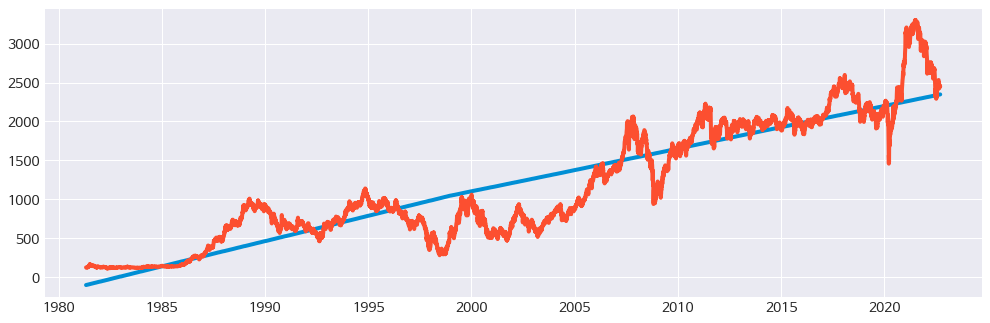

In [ ]:
# 시계열 차트
plt.figure(figsize=(15,5))
plt.plot(pred["Date"],fit_fn(x))
plt.plot(pred["Date"],pred["Close"])
plt.show()

# 정리

* 상관계수 확인 결과, "Close", "Open", "High", "Low" 컬럼의 값이 비슷함
* Backtesting으로 Strategy 설정해본 결과, 최고 수익률 602%, 현재 수익률 345%로 나왔음 
* AutoTS를 통해 KOSPI 주식이 떨어질 것으로 예상됨

# 참고 자료
> * [데이콘 annsyj94님, "KOSPI 데이터로 시각화 및 AutoTS으로 주식 예측하기"](https://dacon.io/competitions/official/235980/codeshare/6535?page=1&dtype=random)
* [조대표 외 1인, 파이썬으로 배우는 알고리즘 트레이딩 (wikidocs)](https://wikidocs.net/book/110)